In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
true_result = pd.read_csv('../input/gender_submission.csv')

train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
665,666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5000,NaN,S
421,422,0,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C


In [3]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [4]:
# Some imputation need to be done with variables: Age, Cabin and Embarked
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing records in Age are too many which may make the data unbalanced when we impute it with mean of age across the dataset. I recommended to treat this group as a separated bucket from all ages. These people may be in a lower class and don't have a lot of profile information when they buy a ticket

In [5]:
# describle 1 column to get quartile values
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

__Variable Transformation__

In [6]:
import re
def clean_variable(df):
    df.Age = df.Age.fillna(-0.5)
    #df.Age = df.Age.fillna(df.Age.mean())
    #df.Age = pd.cut(df.Age, (-1, 0, 20, 28, 38, 90), labels=['Unknown','1-quantile', '2-quantile', '3-quantile', '4-quantile'])
    df.Age = pd.cut(df.Age, (-1,0, 18, 65, 100), labels=['Unknown','Child', 'Adult', 'Senior'])
    df.Embarked = df.Embarked.fillna('N')
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    #df.Ticket = df.Ticket.apply(lambda x: x[0])
    df.Fare = df.Fare.fillna(-0.5)
    #df.Fare = pd.cut(df.Fare, (-1, 0, 8, 14, 31, 600), labels=['Unknown','1-quantile', '2-quantile', '3-quantile', '4-quantile'])
    df.Fare = pd.cut(df.Fare,  (-1, 15, 1000), labels=['Economy', 'Business'])
    df['Title'] = df.Name.apply(lambda x: x.split(', ')[1].split('.')[0])
    df= df.drop(['Name' ], axis = 1)
    return df
train = clean_variable(train)
test = clean_variable(test)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,Adult,1,0,A/5 21171,Economy,N,S,Mr
1,2,1,1,female,Adult,1,0,PC 17599,Business,C,C,Mrs
2,3,1,3,female,Adult,0,0,STON/O2. 3101282,Economy,N,S,Miss
3,4,1,1,female,Adult,1,0,113803,Business,C,S,Mrs
4,5,0,3,male,Adult,0,0,373450,Economy,N,S,Mr


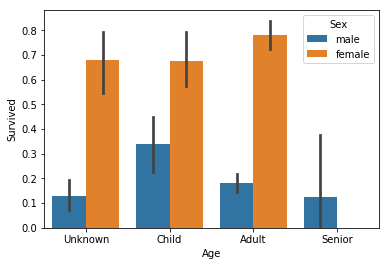

In [7]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=train);

In [8]:
#unique titles in both train and test
pd.concat([train[['Title']],test[['Title']]],axis = 0).Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [9]:
# normalize the titles
normalized_titles = {
    "Capt":"Officer",        "Col":"Officer",    "Major":"Officer",    "Dr":"Officer",              "Rev":"Officer",
    "Jonkheer":"Royalty",    "Don":"Royalty",    "Sir" :"Royalty",     "the Countess":"Royalty",    "Dona":"Royalty",    "Lady" :"Royalty",
    "Mme":"Mrs",             "Ms":"Mrs",         "Mrs" :"Mrs",
    "Mlle":"Miss",           "Miss" :"Miss",
    "Mr" :"Mr",
    "Master" :"Master"
    }
# map the normalized titles to the current titles 
train.Title = train.Title.map(normalized_titles)
test.Title = test.Title.map(normalized_titles)

In [10]:
pd.concat([train[['Title']],test[['Title']]],axis = 0).Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

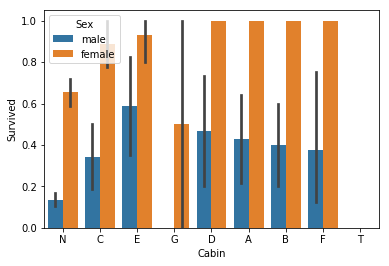

In [11]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=train);

__Label Encoding__

In [12]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Title','Embarked']#,'Ticket'
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,1,0,1,0,A/5 21171,1,7,3,2
1,2,1,1,0,0,1,0,PC 17599,0,2,0,3
2,3,1,3,0,0,0,0,STON/O2. 3101282,1,7,3,1
3,4,1,1,0,0,1,0,113803,0,2,3,3
4,5,0,3,1,0,0,0,373450,1,7,3,2


__Splitting up the Training Data__

In [13]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['Survived', 'PassengerId','Ticket'], axis=1)
y_all = train['Survived']

num_test = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=123)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
416,2,0,0,1,1,0,7,3,3
801,2,0,0,1,1,0,7,3,3
512,1,1,0,0,0,0,4,3,2
455,3,1,0,0,0,1,7,0,2
757,2,1,1,0,0,1,7,3,2


__Fitting and Tuning an Algorithm__

__DecisionTreeClassifier__ (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = DecisionTreeClassifier()

# Choose some parameter combinations to try
parameters = {'criterion': ['entropy', 'gini'],
              'splitter': ['best','random'],
              'max_depth': [2, 3, 5, 10, 20], 
              'min_samples_split': [3, 5, 8, 10],
              'min_samples_leaf': [1,2,5], 
              'max_features': ['log2','sqrt','auto'], 
              'random_state': [1234]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,cv=3,iid = True)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)
print(clf)

train_predictions = clf.predict(X_train)
print('train accuracy: '+str(accuracy_score(y_train, train_predictions)))
test_predictions = clf.predict(X_test)
print('test accuracy: '+str(accuracy_score(y_test, test_predictions)))

#Feature importances
feature_importance_df = pd.DataFrame(
                    {'Features': X_train.columns,
                     'Importances': clf.feature_importances_
                    }).sort_values(by=['Importances'],ascending=False)
feature_importance_df

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')
train accuracy: 0.8073836276083467
test accuracy: 0.8171641791044776


,Features,Importances
1,Sex,0.584042
0,Pclass,0.143655
6,Cabin,0.143455
3,SibSp,0.065407
4,Parch,0.015826
2,Age,0.015571
8,Title,0.015456
5,Fare,0.008755
7,Embarked,0.007832


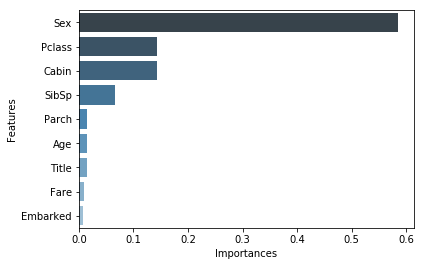

In [15]:
#Feature importance plot
sns.barplot(x="Importances", y="Features", data=feature_importance_df,palette="Blues_d")

__Validate with KFold__

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

Parameters:	
- n_splits : int, default=3: Number of folds. Must be at least 2. - Changed in version 0.20: n_splits default value will change from 3 to 5 in v0.22.
- shuffle : boolean, optional: Whether to shuffle the data before splitting into batches.
- random_state : int, RandomState instance or None, optional, default=None. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random. Used when shuffle == True.

Methods:
- get_n_splits([X, y, groups])	Returns the number of splitting iterations in the cross-validator
- split(X[, y, groups])	Generate indices to split data into training and test set.

In [16]:
from sklearn.model_selection  import KFold

def run_kfold(clf):
    kf = KFold(n_splits=5) # n_sample in each split will be 4:1 (total = 5) for train and test
    kf.get_n_splits(X_all)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

run_kfold(clf)

Fold 1 accuracy: 0.8268156424581006
Fold 2 accuracy: 0.7865168539325843
Fold 3 accuracy: 0.8202247191011236
Fold 4 accuracy: 0.7584269662921348
Fold 5 accuracy: 0.8595505617977528
Mean Accuracy: 0.8103069487163392


__Predict the Actual Test Data__

And now for the moment of truth. Make the predictions, export the CSV file, and upload them to Kaggle.

In [17]:
ids = test['PassengerId']
predictions = clf.predict(test.drop(['PassengerId','Ticket'], axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [18]:
#Check same PassengerId
y_pred_id = output['PassengerId'].tolist()
y_true_id = true_result['PassengerId'].tolist()
print('If PassengerId is in the right order: '+str(y_pred_id == y_true_id))
#Public score
y_pred = output['Survived'].tolist()
y_true = true_result['Survived'].tolist()
print('Public score: '+str(accuracy_score(y_true, y_pred)))

If PassengerId is in the right order: True
Public score: 0.8732057416267942
